<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/3%20action%20deep%20q%20regularized%20i%20dk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas_ta
!pip install tf_agents[reverb]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=ac1dca9ef53909061aab4dedf57be02932d88950b0db27e3d43be3fe8bae2c73
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52

In [120]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb
import random

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.policies import greedy_policy
from tf_agents.policies.epsilon_greedy_policy import EpsilonGreedyPolicy
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [158]:
num_iterations = 20000000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 3  # @param {type:"integer"}
eval_interval = 100000  # @param {type:"integer"}

In [122]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [123]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


In [124]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = get_relative_change(close,"Change")

sma = ta.sma(close,20,offset = -20)
sma2 = ta.sma(close,30,offset = -20)
DIFF = sma-sma2
DIFF = DIFF/np.std(DIFF)
DIFF.name = 'DIFF'

INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI,DIFF],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
diff = INDICATORS.pop('DIFF')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev
np.set_printoptions(suppress=True)

0.10848537423653505
(93050,)


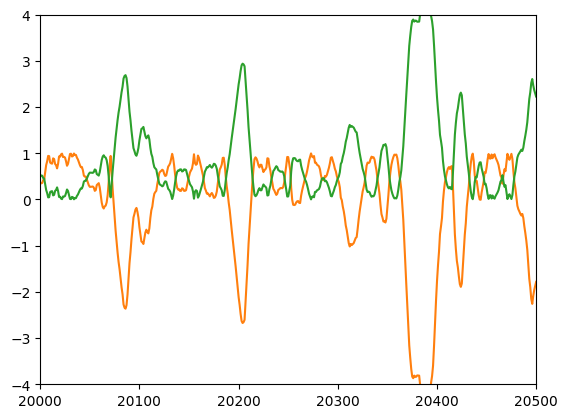

In [125]:
diff_adj = ((abs(diff)*-1.25)+1)
print(np.mean(diff_adj))
plt.xlim(20000,20500)
plt.ylim(-4,4)

print(diff.shape)
plt.plot(np.cumsum(change))
plt.plot(diff_adj)
plt.plot(abs(diff))

-0.00659753394752164
0.00659753394752164


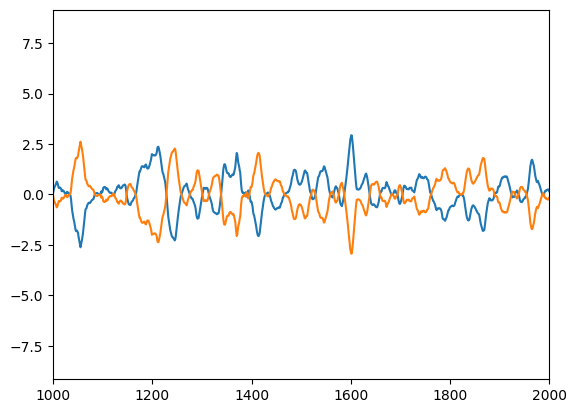

In [126]:
buy_sig = diff
sell_sig = (-diff)

plt.xlim(1000,2000)
sig_dict = {
    'buy': buy_sig,
    'sell': sell_sig,
}

print(np.mean(buy_sig))
print(np.mean(sell_sig))
plt.plot(sig_dict['buy'])
plt.plot(sig_dict['sell'])

In [127]:
print(INDICATORS)

[[0.38187407 1.         0.71428571 0.39334634 0.85330187]
 [0.52438576 0.92857143 0.64285714 0.42260631 0.87272338]
 [0.45394255 0.85714286 0.57142857 0.38867102 0.75057577]
 ...
 [0.52805713 0.71428571 0.07142857 0.48937919 0.62023368]
 [0.5497583  0.64285714 0.         0.56455544 0.65215905]
 [0.5714324  0.57142857 0.         0.63083612 0.67453355]]


(5400.0, 5500.0)

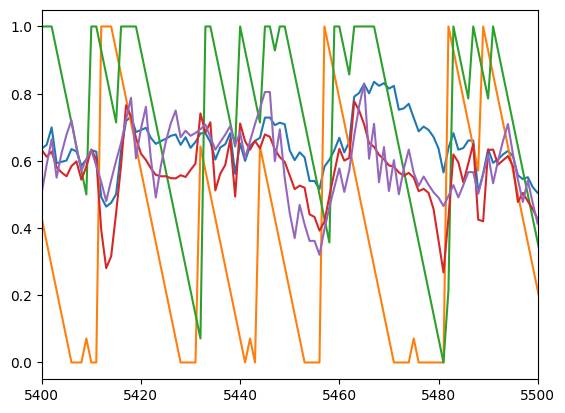

In [128]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [129]:
def custom_formatter(x):
  return f'{x:.4f}'


def test_environment(env, num_steps):
    # Reset the environment
    observation = env.reset()

    # Get the upper bound of the action range
    action_spec = env.action_spec().maximum

    # Loop through the time steps and take random actions
    for _ in range(num_steps):
        # Select a random action from the range of valid values
        action = random.randint(0, action_spec)

        # Execute the action and get the next observation, reward, done, and info
        observation, reward, done, info = env.step(action)

        # Print the current time step
        np.set_printoptions(formatter={'float_kind':custom_formatter})
        print(action,"{:.4f}".format(reward),info[5:12])


In [130]:
def cross(cur_diff,prev_diff):
  if cur_diff > 0 and prev_diff <= 0:
    return 5
  elif cur_diff < 0 and prev_diff >= 0:
    return 5
  else:
    return 0


In [131]:
max_ep_len = 1000

In [167]:
class TradingEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(12,), dtype=np.float32, minimum=-100,maximum=100, name='observation')


    self._state = [0] * 12
    self._episode_ended = False
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self._prev_dff = 0
    self.trade_info = {
    'time': 0,
    'value': 0,
    'direction': 0,
    'max_val': 0,
    'min_val': 0,
    'max_time': 0,
    'min_time': 0
    }


  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_balance(self):
    return self._balance

  def _reset(self):

    self._state = [0] * 12
    self._episode_ended = False
    self._count = random.randint(0,60000)
    self._end_ep = self._count+max_ep_len
    self._balance = 0
    self._prev_diff = 0
    self.trade_info = {
    'time': 0,
    'value': 0,
    'direction': 0,
    'max_val': 0,
    'min_val': 0,
    'max_time': 0,
    'min_time': 0
    }

    return ts.restart(np.array(self._state, dtype=np.float32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()


    mult = 10
    cur_diff = diff[self._count]
    self._prev_diff = cur_diff
    entry_bonus = cross(cur_diff,self._prev_diff)
    profit = 0
    reward = 0
    cur_change = change[self._count+1]/mult

    cur_direction = self.trade_info['direction']

    if action == 0:
      profit = self.trade_info['value']-.05
      self.trade_info['value'] = cur_change
      self.trade_info['direction'] = 1
      self.trade_info['time'] = 0
      self.trade_info['max_val'] = cur_change
      self.trade_info['min_val'] = cur_change
      self.trade_info['max_time'] = 0
      self.trade_info['min_time'] = 0
      reward = ((profit*mult) + cur_diff)+ entry_bonus
    elif action == 1:
      profit = self.trade_info['value']-.05
      self.trade_info['value'] = -cur_change
      self.trade_info['direction'] = -1
      self.trade_info['time'] = 0
      self.trade_info['max_val'] = -cur_change
      self.trade_info['min_val'] = -cur_change
      self.trade_info['max_time'] = 0
      self.trade_info['min_time'] = 0
      reward = ((profit*mult) + -cur_diff)+ -entry_bonus
    elif action == 2:
      profit = self.trade_info['value']
      self.trade_info['value'] = 0
      self.trade_info['direction'] = 0
      self.trade_info['time'] = 0 if cur_direction != 0 else self.trade_info['time'] + .01
      self.trade_info['max_val'] = 0
      self.trade_info['min_val'] = 0
      self.trade_info['max_time'] = 0
      self.trade_info['min_time'] = 0
      reward = profit*mult
    else:
      self.trade_info['value'] += cur_change*cur_direction
      self.trade_info['time'] += .01
      self.trade_info['max_val'] = max(self.trade_info['value'],self.trade_info['max_val'])
      self.trade_info['min_val'] = min(self.trade_info['value'],self.trade_info['min_val'])
      self.trade_info['max_time'] = 0 if self.trade_info['max_val']==self.trade_info['value'] else self.trade_info['max_time']+.01
      self.trade_info['min_time'] = 0 if self.trade_info['min_val']==self.trade_info['value'] else self.trade_info['min_time']+.01
      reward = cur_diff*cur_direction



    self._balance += profit

    info_list = [
        self.trade_info['value'],
        self.trade_info['direction'],
        self.trade_info['time'],
        self.trade_info['max_val'],
        self.trade_info['min_val'],
        self.trade_info['max_time'],
        self.trade_info['min_time']
    ]


    #update state
    self._state = np.append(INDICATORS[self._count],info_list)

    if self._count >= self._end_ep:
      self._episode_ended = True

    self._count += 1

    if self._episode_ended:
      reward = (self._balance+self.trade_info['value'])*mult
      return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
    else:
      return ts.transition(
          np.array(self._state, dtype=np.float32), reward=reward, discount=.8)

In [168]:
env = TradingEnv()

utils.validate_py_environment(env, episodes=2)

In [169]:
test_environment(env,100)

1 -2.2774 [0.0559 -1.0000 0.0000 0.0559 0.0559 0.0000 0.0000]
0 1.8324 [-0.0187 1.0000 0.0000 -0.0187 -0.0187 0.0000 0.0000]
3 1.7509 [0.0198 1.0000 0.0100 0.0198 -0.0187 0.0000 0.0100]
3 1.6556 [0.4045 1.0000 0.0200 0.4045 -0.0187 0.0000 0.0200]
0 4.9529 [0.0847 1.0000 0.0000 0.0847 0.0847 0.0000 0.0000]
3 1.1074 [-0.0283 1.0000 0.0100 0.0847 -0.0283 0.0100 0.0000]
0 0.0626 [0.3447 1.0000 0.0000 0.3447 0.3447 0.0000 0.0000]
2 3.4472 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
3 0.0000 [0.0000 0.0000 0.0100 0.0000 0.0000 0.0000 0.0000]
0 -0.7511 [-0.1371 1.0000 0.0000 -0.1371 -0.1371 0.0000 0.0000]
3 -0.5327 [-0.1679 1.0000 0.0100 -0.1371 -0.1679 0.0100 0.0000]
3 -0.8176 [-0.1708 1.0000 0.0200 -0.1371 -0.1708 0.0200 0.0000]
1 -1.0952 [-0.0667 -1.0000 0.0000 -0.0667 -0.0667 0.0000 0.0000]
3 1.4147 [0.0278 -1.0000 0.0100 0.0278 -0.0667 0.0000 0.0100]
2 0.2776 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
1 1.1714 [0.1072 -1.0000 0.0000 0.1072 0.1072 0.0000 0.0000]
2 1.0724 [0

In [170]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [171]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3)


In [172]:
fc_layer_params = (20, 5)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


In [173]:
def activity_regularizer(multiplier):
    def regularizer(y_pred):
        mean = tf.reduce_mean(y_pred)
        variance = tf.math.reduce_variance(y_pred)
        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))
    return regularizer

In [174]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [175]:
class CustomNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomNoiseLayer, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            first_5_inputs = inputs[:, :5]  # Split the first 5 inputs
            noisy_inputs = tf.keras.layers.Dropout(self.rate)(first_5_inputs)  # Apply dropout to the first 5 inputs
            noisy_inputs = tf.concat([noisy_inputs, inputs[:, 5:]], axis=1)  # Combine noisy inputs with the remaining inputs
            return noisy_inputs
        else:
            return inputs

In [176]:
class CustomNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(CustomNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
      if training:
        first_5_inputs = inputs[:, :5]  # Split the first 5 inputs
        noise = tf.random.normal(tf.shape(first_5_inputs), stddev=self.stddev)  # Generate Gaussian noise
        noisy_inputs = tf.concat([first_5_inputs + noise, inputs[:, 5:]], axis=1)  # Combine noisy inputs with the remaining inputs
        return noisy_inputs
      else:
        return inputs

In [177]:
drop_val = .4
lars_coefficient = .01
reg = tf.keras.regularizers.L2(.01)
q_net = sequential.Sequential([
    CustomNoiseLayer(.01),
    layers.Dense(100,activation='gelu', activity_regularizer=activity_regularizer(0.01)),
    #layers.Dropout(.5),
    layers.Dense(50,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    #layers.Dropout(.4),
    layers.Dense(50,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    #layers.Dropout(.3),
    layers.Dense(50,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    #layers.Dropout(.2),
    layers.Dense(20,activation='gelu',activity_regularizer=activity_regularizer(0.01)),
    #layers.Dropout(.1),
    layers.Dense(num_actions,activation=None,kernel_regularizer=reg, bias_regularizer=reg)
])

In [196]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy = .1,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [197]:
eval_policy = agent.policy

collect_policy = agent.collect_policy

In [198]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [181]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [182]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        last_reward = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            last_reward = time_step.reward  # Store the last reward of the episode
            episode_return = last_reward  # Update episode_return with the last reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


In [183]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [184]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [185]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0.8000, dtype=float32),
  'observation': array([0.3772, 0.9286, 0.7143, 0.3418, 0.4705, 0.0000, 0.0000, 0.0100,
        0.0000, 0.0000, 0.0000, 0.0000], dtype=float32),
  'reward': array(0.0000, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [186]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=tf.data.AUTOTUNE,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(tf.data.AUTOTUNE)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 12), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [187]:
iterator = iter(dataset)
print(iterator)

In [188]:
global_step = tf.compat.v1.train.get_global_step()

In [189]:
"""
from tensorflow.python.training.training import global_step
checkpoint_dir = '/tmp/checkpointer'
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
)
"""

"\nfrom tensorflow.python.training.training import global_step\ncheckpoint_dir = '/tmp/checkpointer'\ntrain_checkpointer = common.Checkpointer(\n    ckpt_dir=checkpoint_dir,\n    max_to_keep=1,\n    agent=agent,\n    policy=agent.policy,\n    replay_buffer=replay_buffer,\n)\n"

In [ ]:
botzmann policy

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)



for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    #train_checkpointer.save(0)

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 1000: loss = 1.701019048690796
step = 2000: loss = 1.5500577688217163
step = 3000: loss = 1.2196745872497559
step = 4000: loss = 1.3347079753875732
step = 5000: loss = 1.855418086051941
step = 6000: loss = 562.5728149414062
step = 7000: loss = 2.306915521621704
step = 8000: loss = 1.2982832193374634
step = 9000: loss = 2.373278856277466
step = 10000: loss = 3.4274098873138428
step = 11000: loss = 3.664597511291504
step = 12000: loss = 1.753151297569275
step = 13000: loss = 2.38653564453125
step = 14000: loss = 1.6691339015960693


In [ ]:
def compute_avg_return_print(environment, policy, num_episodes=10):

  total_return = 0.0
  for episode in range(num_episodes):
    balance_arr = []
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      obs = time_step.observation.numpy()

      balance = env.get_balance()
      balance_arr.append(balance)
      # Print the episode number and observation at each step
      print(f"Episode {episode + 1}: Observation = {obs}")

      episode_return += time_step.reward
    plt.plot(balance_arr)
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [ ]:
avg_return = compute_avg_return_print(eval_env, collect_policy, num_eval_episodes)
print(avg_return)

Streaming output truncated to the last 5000 lines.
  0.0000 0.0000]]
Episode 1: Observation = [[0.5556 0.7857 0.9286 0.5222 0.5725 0.0000 0.0000 0.0100 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.5479 0.7143 0.8571 0.5263 0.5234 0.0000 0.0000 0.0200 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.5381 0.6429 0.7857 0.5066 0.4763 0.0000 0.0000 0.0300 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.5840 0.5714 0.7143 0.5932 0.5294 0.0000 0.0000 0.0400 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.5748 0.5000 0.6429 0.6212 0.4757 0.0000 0.0000 0.0500 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.5102 0.4286 0.5714 0.4972 0.4269 0.0000 0.0000 0.0600 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.4808 0.3571 0.5000 0.3959 0.3753 0.0000 0.0000 0.0700 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: Observation = [[0.4730 0.2857 0.4286 0.3795 0.3248 0.0000 0.0000 0.0800 0.0000 0.0000
  0.0000 0.0000]]
Episode 1: 

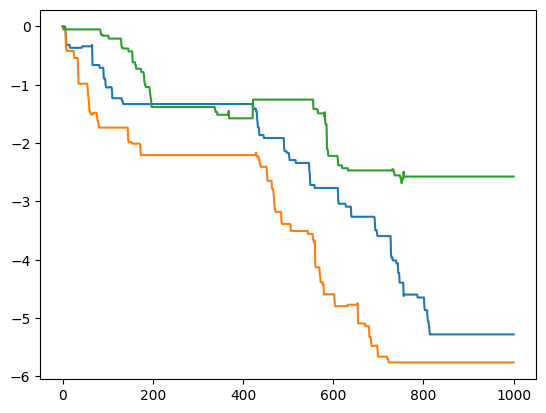

In [195]:
avg_return = compute_avg_return_print(eval_env, eval_policy, num_eval_episodes)
print(avg_return)

In [194]:
weights = q_net.get_weights()
print(weights)

[array([[0.2624, 0.0830, 0.4452, ..., -0.1396, 0.1364, -0.4182],
       [-0.0947, -1.4406, -0.1408, ..., -0.2125, -0.6019, 0.8881],
       [-0.1363, 0.3794, 0.2162, ..., -0.1557, 0.0696, 0.0872],
       ...,
       [-1.1361, -0.7013, -0.4376, ..., 0.4661, -0.7659, 0.0645],
       [1.1492, 0.2352, -0.1652, ..., 0.8584, -0.7111, 0.8272],
       [-2.8154, -0.6064, -1.8371, ..., -0.1036, -3.6991, 1.5462]],
      dtype=float32), array([-0.1508, 0.1174, -0.2494, 0.0272, 0.2768, -0.3373, -0.2065,
       -0.0840, 0.2736, 0.0854, 0.3434, 0.1662, 0.2953, 0.1374, -0.2336,
       0.3928, -0.2036, 0.3594, 0.2578, -0.2623, -0.1327, 0.3736, -0.1957,
       0.1610, 0.0405, -0.1798, 0.4248, 0.1210, 0.0562, -0.1123, -0.2024,
       0.2570, -0.2207, 0.4126, -0.2034, -0.0684, 0.1429, -0.0663, 0.1689,
       0.1536, 0.2411, 0.2837, 0.1931, -0.2444, 0.0931, 0.2261, -0.1968,
       0.3977, 0.2647, -0.2003, -0.1632, 0.0046, -0.2536, 0.1834, -0.2045,
       0.3774, 0.0899, -0.0510, -0.1528, -0.2692, 0.4007, -0

In [ ]:
content/drive/MyDrive